In [1]:
import matplotlib.pyplot as plt
import math as m
import numpy as np  # 1.7 or higher
from ipywidgets import interactive
from IPython.display import display
from PIL import Image


import qgrid
import pandas as pd

import sympy as sym
sym.init_printing(order="none")
from sympy.vector import CoordSys3D
import sympy.vector as symvec


np.set_printoptions(suppress=True, formatter={'float_kind':'{:14.4f}'.format})  
%matplotlib inline

def display_image(path):
    pil_im = Image.open(path)
    display(pil_im)

#  jupyter nbconvert --no-input --to pdf RotorHead.ipynb 

### Introduction
 
I wanted to learn more about how a helicopter works, specifically how the rotors are controlled.  So I built a rotor-head out of LEGO and did some math.  I also relearned a lot about typesetting equations I knew about a decade ago.  I also learned about a method of helicopter control known as cyclic-collective pitch mixing, which is the algorithm I'll be discussing here.
 
### Definitions

<dl>
    
<dt>Helicopter</dt>
<dd>An aircraft that uses airflow over a rotating wing to generate lift, rather than using thrust to push a fixed wing through the air as in a traditional airplane.  A generic helicopter has a main rotor that generates life, and a tail rotor that counteracts the yaw induced by the main rotor torque on the fuselage and provides directional control.  The main rotor of is attached to the fuselage by an assembly known as the rotor-head.  The drive shaft for the main rotor emerges from the transmission through the top of the fuselage.</dd>
<dd>The primary controls of a helicopter are a stick, called the cyclic, a lever, called the collective, and a pair of pedals, called anti-torque pedals.  The throttle is typically managed mechanically to 
keep the rotor RPM constant.
The cyclic stick controls roll and pitch of the helicopter.  The anti-torque pedals control the thrust of the tail rotor.  The collective changes the angle of attack of the main rotor, to regulate the thrust
of the rotor, but can really be thought of as the "gas pedal" of the helicopter.</dd>
    
    
<dt>Swashplate</dt>
<dd>A swashplate is a device that allows a rotating element to be inclined with two degrees of freedom, pitch and roll, and also move vertically.  The bottom half is attached to three linear actuators,
which provide all degrees of freedom.  The rotating top half is linked to the drive shaft through the "scissor-link".  Push rods connected to the top of the swashplate vary the pitch of the rotors based on the cyclic and collective inputs.</dd>

</dl>

### Coordinate systems

 - P0 is origin of coordinate system, centered under the mast of the helicopter.
 - Positive X is pointing to the front of the helicopter.
 - Positive Y is pointing port.
 - Positive Z is pointing up.

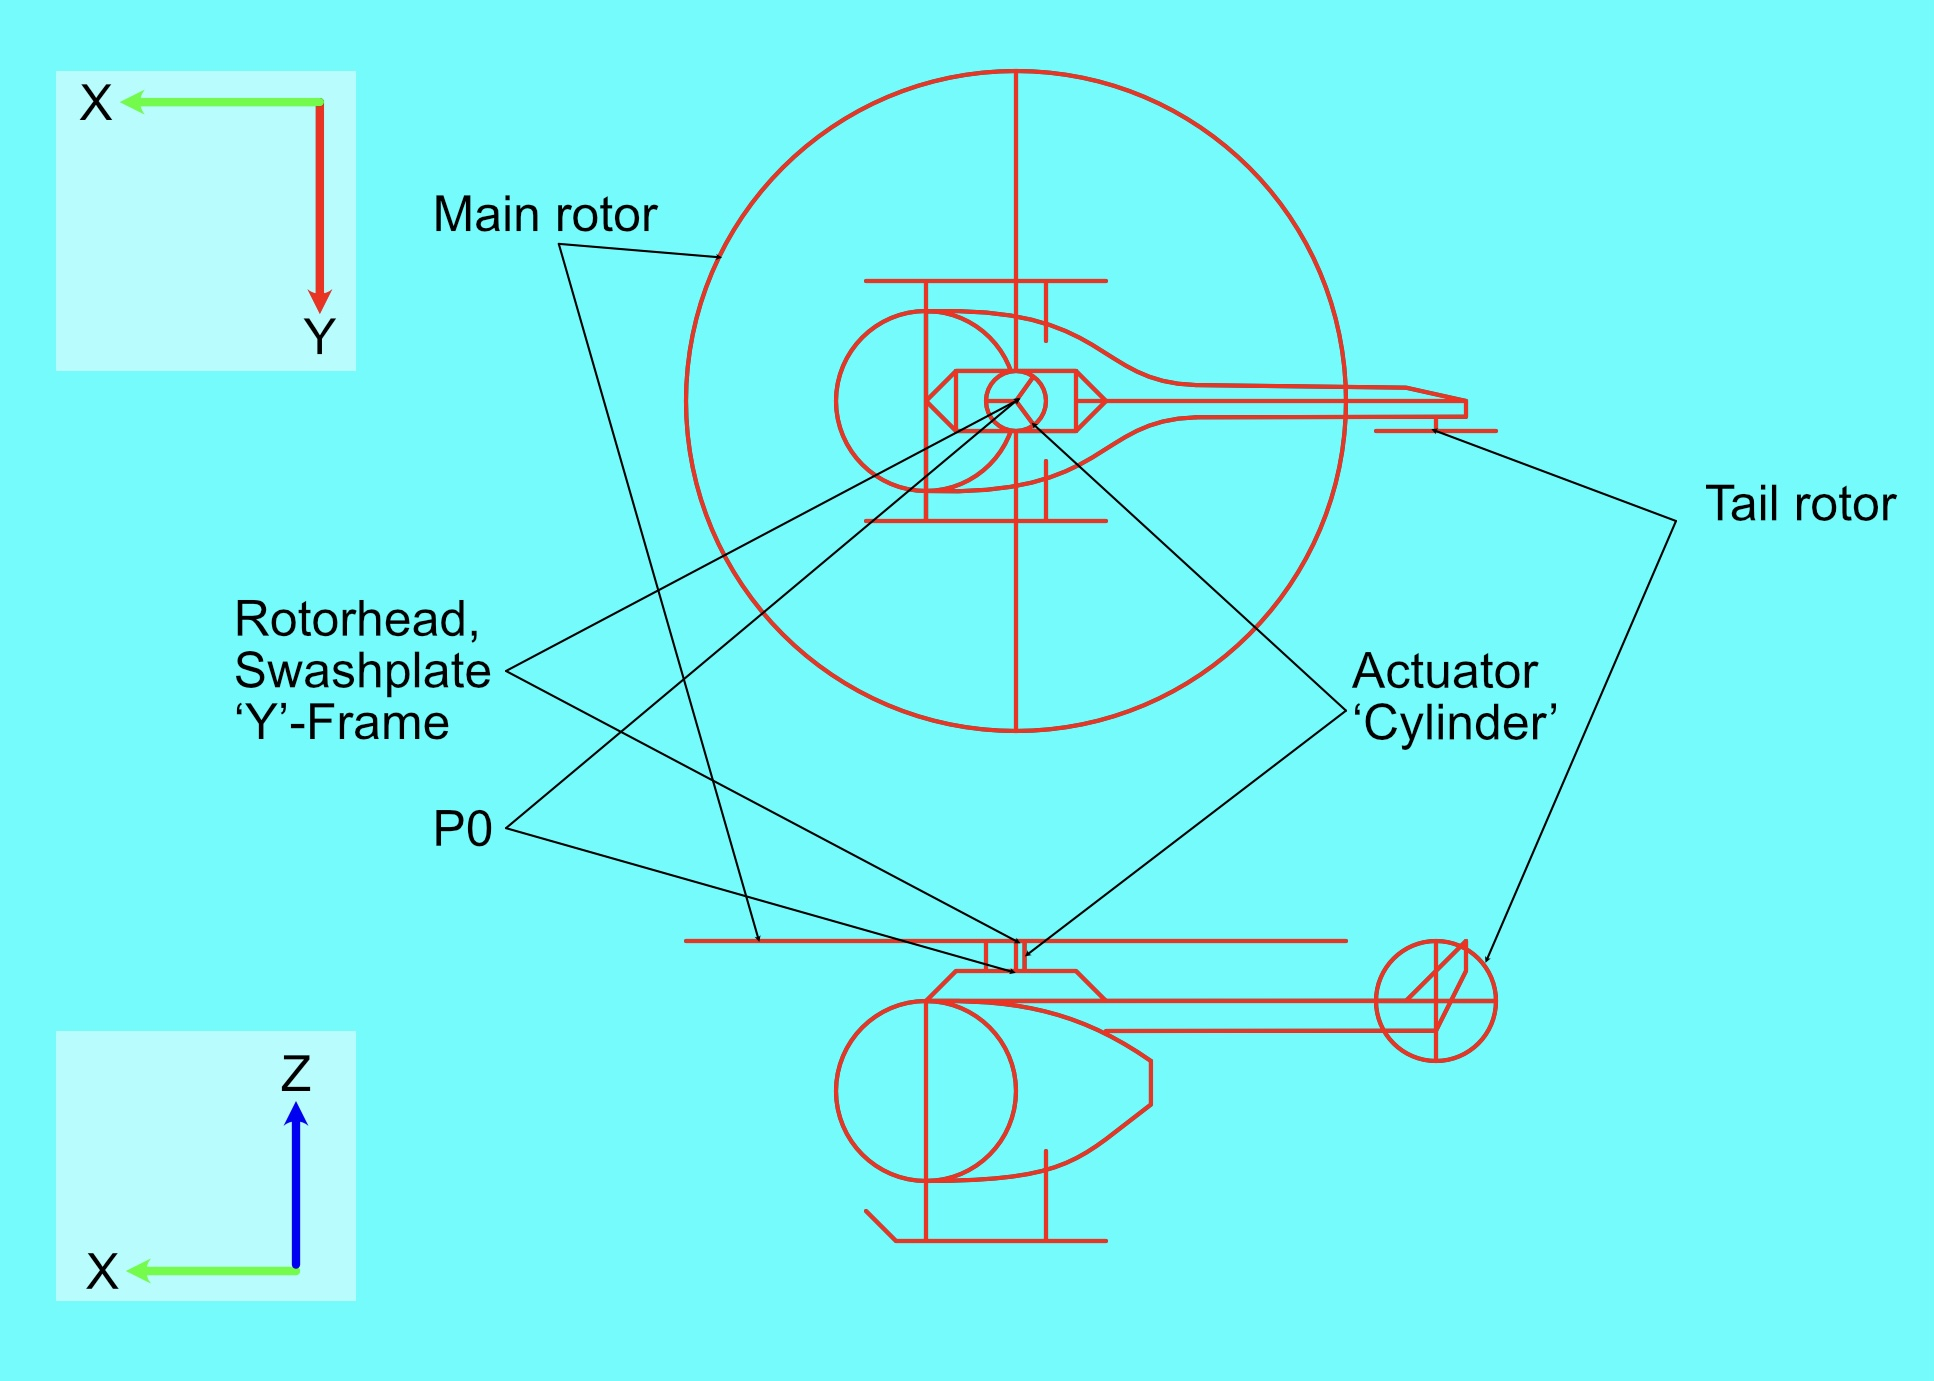

In [2]:
display_image('helidiag.jpg')

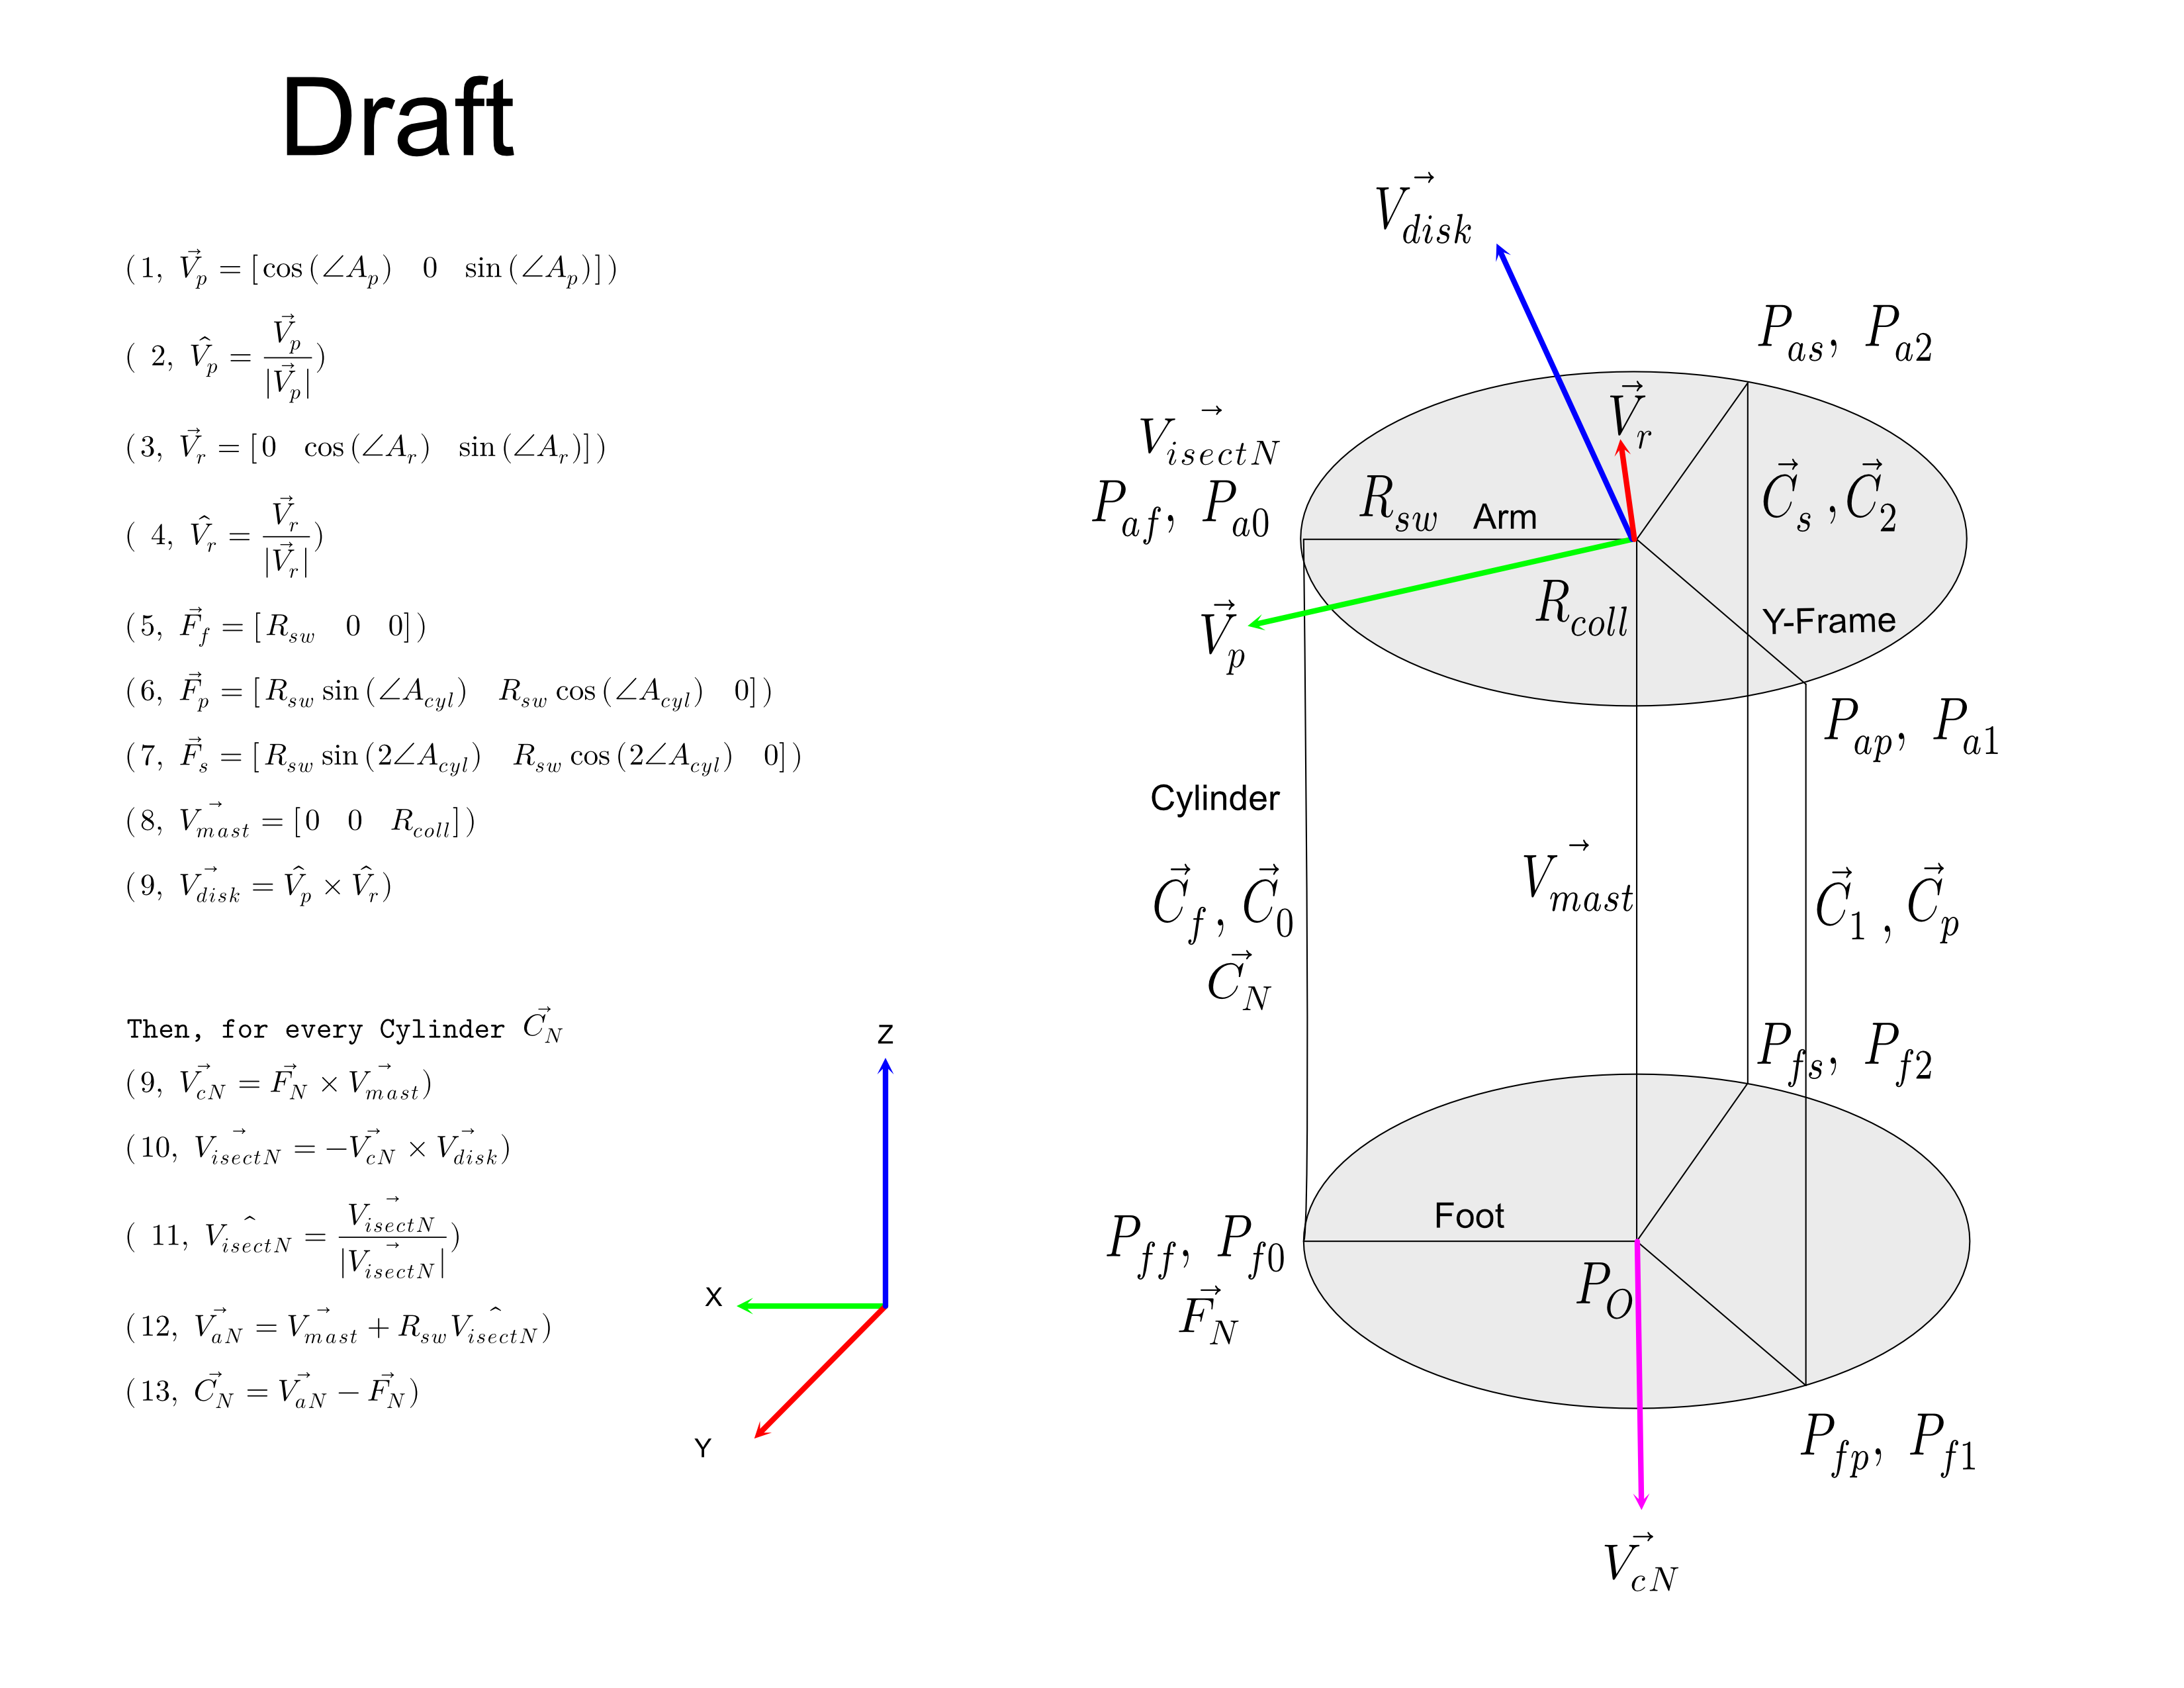

In [3]:
display_image('system.png')

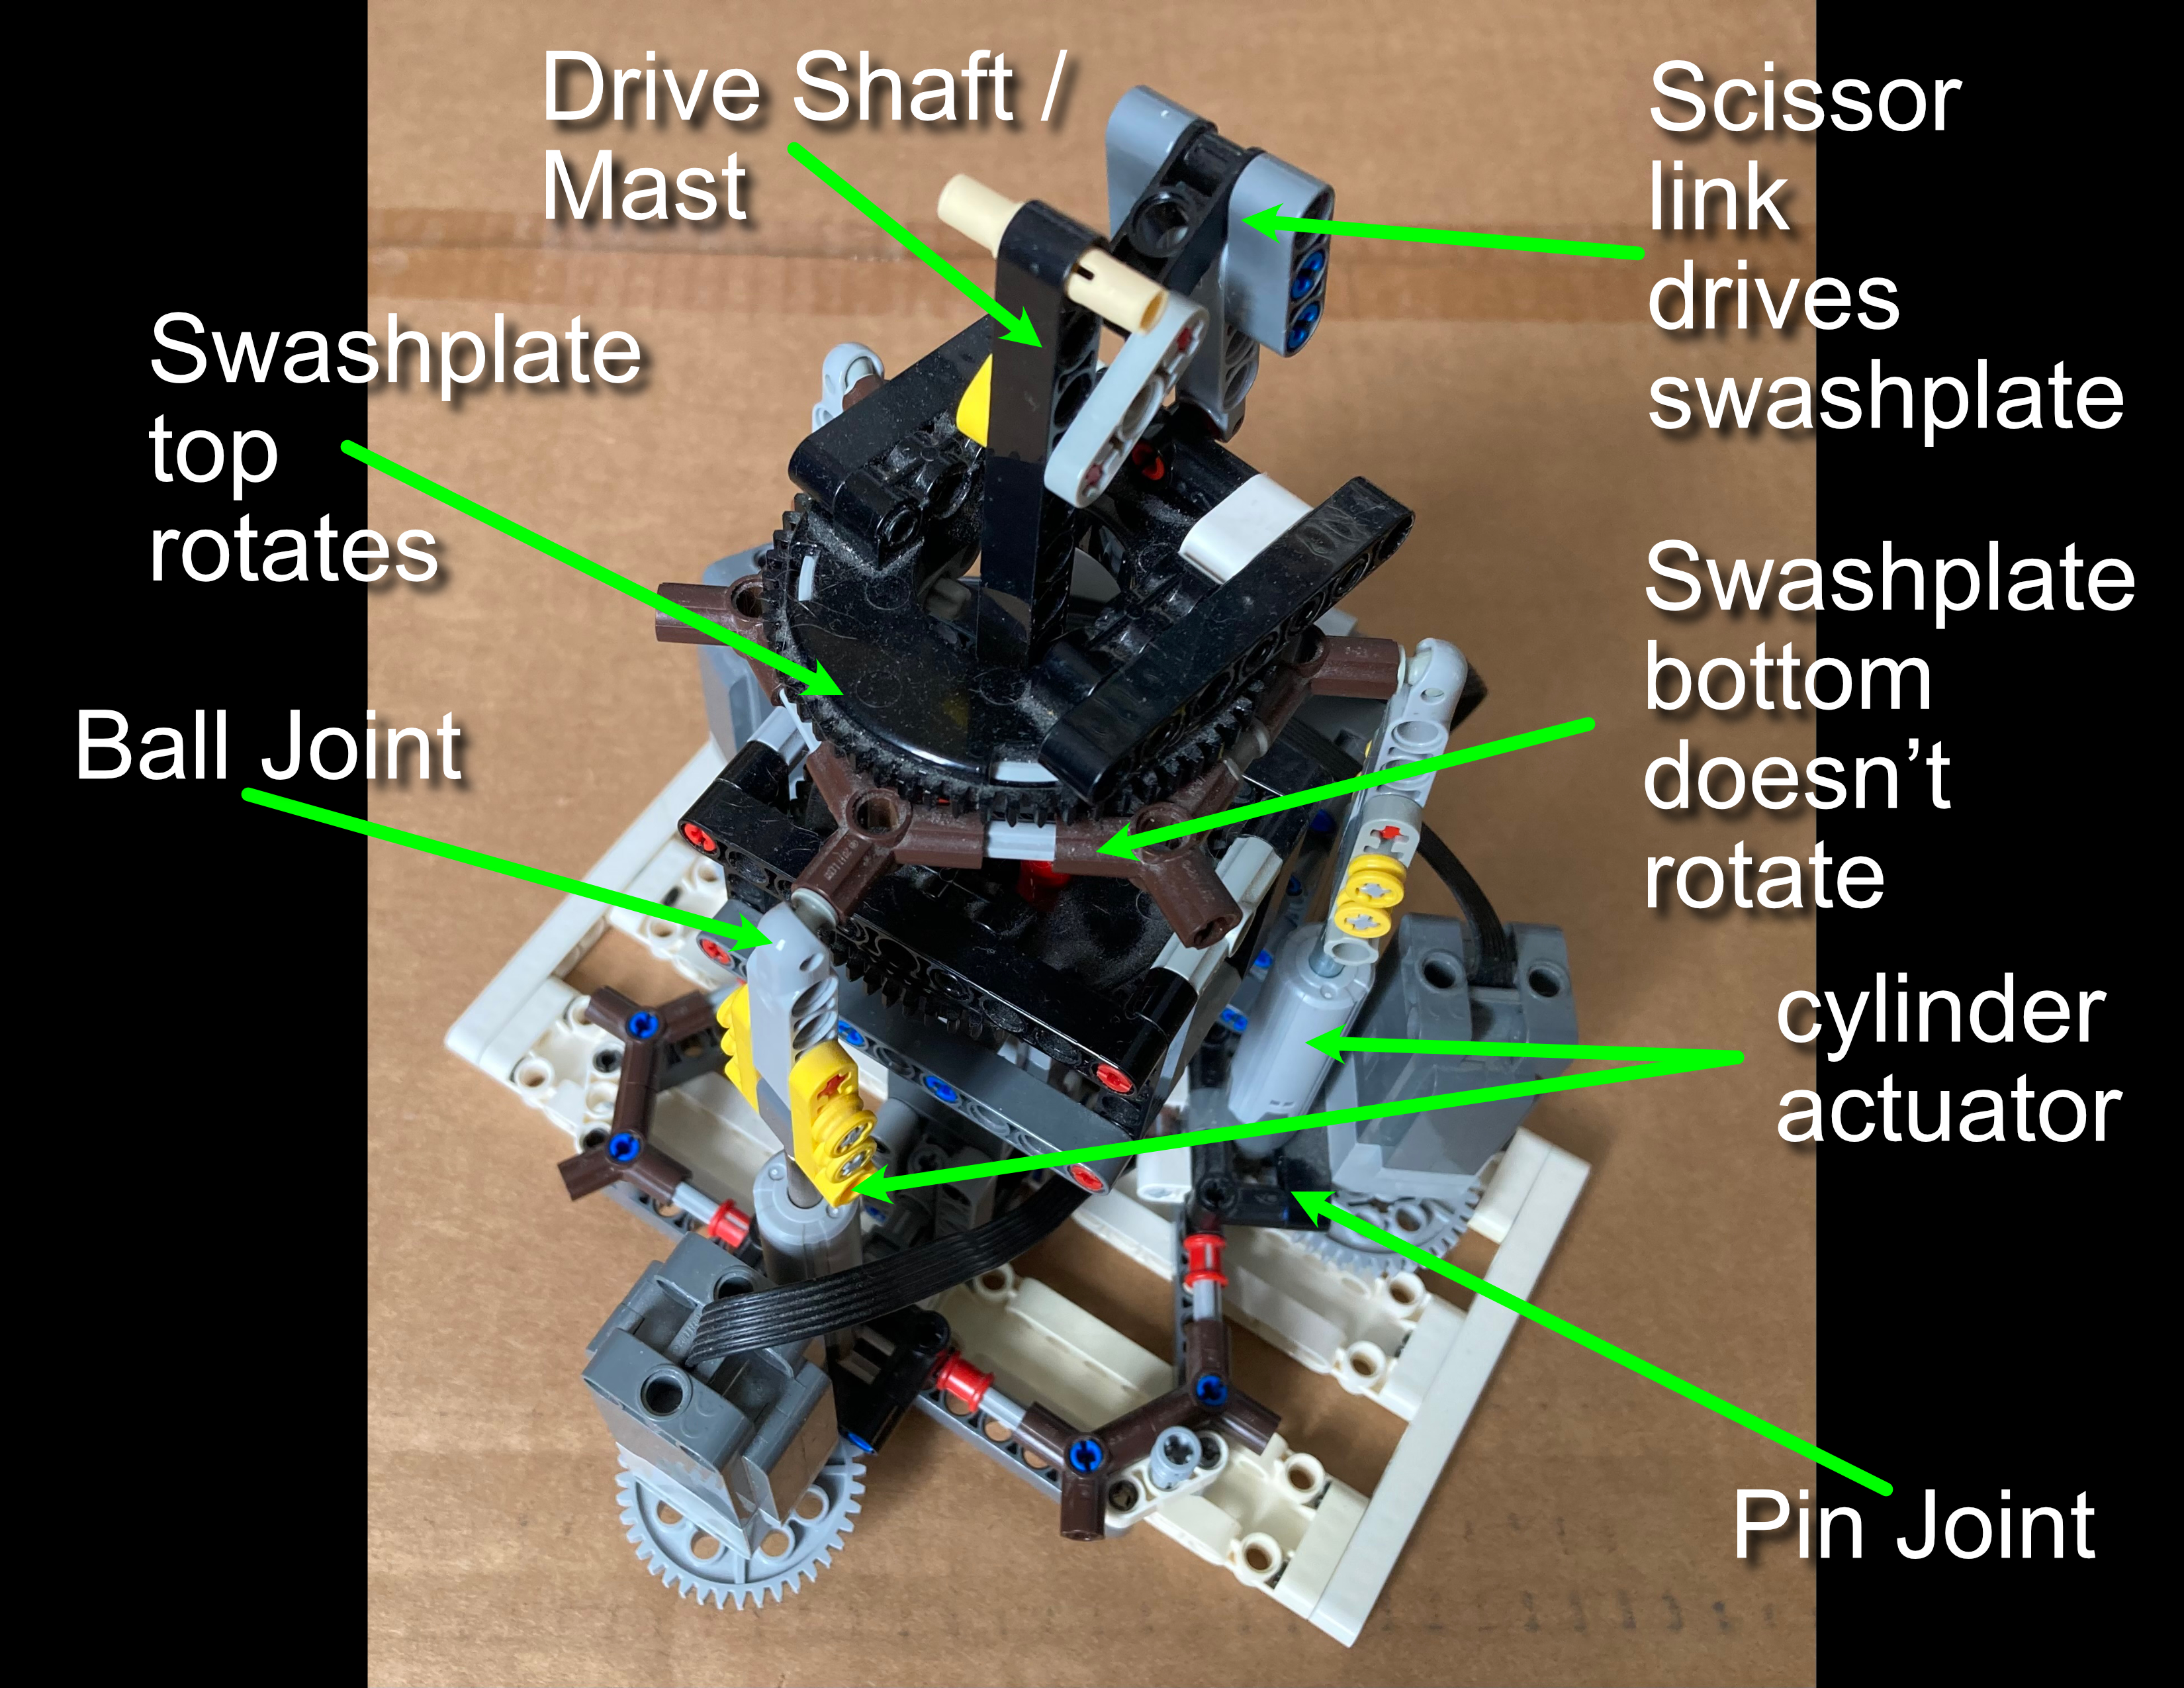

In [4]:
display_image('apparatus.JPG')

### System Description

A two-part rotating swashplate, the bottom half of which is represented as a Y-shaped frame
rotating around a spherical bearing, which in turn surrounds a bushing through which the
drive shaft runs.  This allows the swashplate to pitch and roll around the spherical bearing, 
which in turn moves up and down on the drive shaft.  The arms of the Y-shaped frame will be
referred to as swashpate arms, each with a length of Rsw.  The center of the Y-shaped frame is
referred to as Pcoll, and represents the hight of the rotorhead over the Origin.  Pcoll can vary
in Z-height regulated by the collective position.  The ends of the arms are referred to as PaN,
with N proceeding clockwise from the front.
The arms are connected to the helicopter with linear actuators, which will be referred to as
cylinders.  The cylinders are connected to the ends of the arms with ball joints, and to the base 
XY plane by hinges on "feet", which have an identical Y-shape to the swashplate frame.  
Thus, the cylinders can rotate towards the origin along their feet.  The length of these feet
is the same as the length of the arms Rsw, but needn't be.  The cylinders are located 120∘ around
a circle around the Origin, but don't need to be regularly distributed.
The ends of the feet are Pfn.

∠Pff PO Pfp = 120∘

∠Pff PO Pfs = 120∘

For convenience, cylinders also have position names.  C0 is Cf, C1 is Cp, and C2 is Cs.  Similarly, Paf is equivalent to Pa0, Pff is Pf0, and so on, with "f", "p", and "s" abbreviating front, port, and starboard.

Each cylinder has a minimum and maximum length, Cmin and Cmax

The cyclic input is used to make Pitch and Roll vectors Vp and Vr, and collective the scalar
Pcoll.

The plane of the rotor is defined by Pcoll, the nominal height of the collective, as well as the
three points Paf, Pap, and Pas.  This plane is manipulated around the Y axis by the pitch input
of the cyclic, and around the x axis by the roll input of the cyclic.

In [5]:
P0 = sym.Symbol(r'P_O');  #Origin of XYZ system
Rcoll = sym.Symbol(r'R_{coll}') #height of collective above origin
Rsw = sym.Symbol(r'R_{sw}') #radius of swashplate arms from P_coll

Ap = sym.Symbol(r'\angle{A_p}') #pitch angle
Ar = sym.Symbol(r'\angle{A_r}') #roll angle
Acyl = sym.Symbol(r'\angle{A_{cyl}}') # cylinder spacing


Cf, C0 = sym.symbols(r'\vec{C_f},\vec{C_0}') 
Cp, C1 = sym.symbols(r'\vec{C_p},\vec{C_1}')
Cs, C2 = sym.symbols(r'\vec{C_s},\vec{C_2}')

# Front linear actuator, vector representing length
Ff, F0 = sym.symbols(r'\vec{F_f},\vec{F_0}') 
Fp, F1 = sym.symbols(r'\vec{F_p},\vec{F_1}') #Port linear actuator
Fs, F2 = sym.symbols(r'\vec{F_s},\vec{F_2}') #Starboard linear actuator

Vmast = sym.symbols(r'\vec{V_{mast}}')
Vdisk = sym.symbols(r'\vec{V_{disk}}')

Visectn, Visectnhat = sym.symbols(r'\vec{V_{isectN}},\hat{V_{isectN}}')
Vcn, Cn, Fn= sym.symbols(r'\vec{V_{cN}},\vec{C_N},\vec{F_N}')
Van, Pfn = sym.symbols(r'\vec{V_{aN}}, P_{fn}')

Paf, Pa0 = sym.symbols(r'P_a_f,P_a_0') #End of front swashplate arm
Pap, Pa1 = sym.symbols(r'P_a_p,P_a_1') #End of port swashplate arm
Pas, Pa2 = sym.symbols(r'P_a_s,P_a_2') #End of starboard swashplate arm

Pff, Pf0 = sym.symbols(r'P_f_f,P_f_0') #End of front swashplate foot
Pfp, Pf1 = sym.symbols(r'P_f_p,P_f_1') #End of port swashplate foot
Pfs, Pf2 = sym.symbols(r'P_f_s,P_f_2') #End of starboard swashplate foot

# cylinder minimum length, cylinder maximum length
Cmin, Cmax = sym.symbols("C_m_i_n C_m_a_x")

#Pitch vector from cyclic, Roll vector from cyclic
Vp, Vr = sym.symbols(r'\vec{V_p} \vec{V_r}')
Vrhat = sym.Symbol(r'\hat{V_r}') #unit vector versons of above
Vphat = sym.Symbol(r'\hat{V_p}')

display((P0, Rcoll, Rsw, Ap, Ar, Cf, C0, Cp, C1, Cs, C2))
display((Paf, Pa0, Pap, Pa1, Pas, Pa2, Pff, Pf0, Pfn))
display((Pfp, Pf1, Pfs, Pf2, Cmin, Cmax, Vcn, Van, Cn, Fn))
display((Visectn, Visectnhat, Vmast, Vdisk,  Vp, Vr, Vrhat, Vphat))

In [6]:
def EqsP(A, expr1, expr2, comment=""):
    A.append( (sym.Eq(expr1, expr2, evaluate=False), comment) )
    
eqs1 = []
EqsP(eqs1, Vp, sym.Matrix([sym.cos(Ap), 0, sym.sin(Ap)]).T)
EqsP(eqs1, Vphat, Vp/abs(Vp))

EqsP(eqs1, Vr, sym.Matrix([0, sym.cos(Ar), sym.sin(Ar)]).T)
EqsP(eqs1, Vrhat, Vr/abs(Vr))

EqsP(eqs1, Ff, sym.Matrix([Rsw, 0, 0]).T)
EqsP(eqs1, Fp, sym.Matrix([Rsw*sym.sin(Acyl), Rsw*sym.cos(Acyl), 0]).T)
EqsP(eqs1, Fs, sym.Matrix([Rsw*sym.sin(2*Acyl), Rsw*sym.cos(2*Acyl), 0]).T)

EqsP(eqs1, Vmast, sym.Matrix([0, 0, Rcoll]).T)

# order is important here
EqsP(eqs1, Vdisk, symvec.Cross(Vphat, Vrhat))

# for each cylinder, Vcn normal of plane formed by foot and mast
eqs2 = []
EqsP(eqs2, Fn, Pfn-P0)
EqsP(eqs2, Vcn, symvec.Cross(Fn, Vmast))
EqsP(eqs2, Visectn, symvec.Cross(Vdisk, Vcn))
EqsP(eqs2, Visectnhat, Visectn/abs(Visectn))
EqsP(eqs2, Van, Rsw*Visectnhat+Vmast)
EqsP(eqs2, Cn, Van - Fn)

def showeqs(eqs, offset=1):
    for i, ecom in enumerate(eqs):
        numsym = sym.Symbol(f"{i+offset}")
        (e, com) = ecom
        #display(f"comment: {com}")
        display((numsym, e))

showeqs(eqs1)
display("Then, for every Cylinder")
display(Cn)
showeqs(eqs2, len(eqs1)+1)



(1, \vec{V_p} = [cos(\angle{A_p})  0  sin(\angle{A_p})])

(3, \vec{V_r} = [0  cos(\angle{A_r})  sin(\angle{A_r})])

(5, \vec{F_f} = [R_{sw}  0  0])

(6, \vec{F_p} = [R_{sw}⋅sin(\angle{A_{cyl}})  R_{sw}⋅cos(\angle{A_{cyl}})  0])

(7, \vec{F_s} = [R_{sw}⋅sin(2⋅\angle{A_{cyl}})  R_{sw}⋅cos(2⋅\angle{A_{cyl}}) 
 0])

(8, \vec{V_{mast}} = [0  0  R_{coll}])

'Then, for every Cylinder'

### Source Code of Solve Function

```python
def solve(self, pitch, roll, collpct):
    Vp = lin.vector(m.cos(m.radians(pitch)), 0, m.sin(m.radians(pitch)))
    Vr = lin.vector(0, m.cos(m.radians(roll)), m.sin(m.radians(roll)))

    # Normal of rotor disk
    Vdisk = lin.cross(Vp, Vr) 
    Vdisk_n = lin.normalize(Vdisk)

    # top of mast at collective setting
    Vmast = lin.vector(0, 0, self.Cmin + collpct*self.Crange) 
    arms = []
    for i, Fn in enumerate(self.feet):
        # Vcn is the plane the cylinder rotates on its foot in, Foot X Mast
        Vcn = lin.cross(Fn, Vmast)
        Vcn_n = lin.normalize(Vcn)

        # Visect is the intersection of the Rotor Disk plane and the Cylinder rotation plane
        Visect = lin.cross(Vdisk_n, Vcn_n) # should be plane intersection
        Visect_n = lin.normalize(Visect)

        # Va is the arm vector as rotated in the cylinder rotation plane
        Va = (self.Rsw * Visect_n) + Vmast

        arms.append(Va)
        cyl_len = lin.vmag(Va - Fn)
        if cyl_len < self.Cmin:
            raise ValueError(f"too short! Cyl: {cyl_len:{4}.{4}} min: {self.Cmin:{4}}")
        elif cyl_len > self.Cmax:
            raise ValueError(f"too long! Cyl: {cyl_len:{4}.{4}} max: {self.Cmax:{4}}")

    (Cf, Cp, Cs) = arms

    #old validation code, cyl_len test above is sufficient
    #self.validate(Cf, Cp, Cs, Vmast, pitch, roll, collpct)

    #successfully validated, save old values and calculate cylinder lengths
    self.s_Cf = Cf
    self.s_Cp = Cp
    self.s_Cs = Cs
    self.s_Vmast = Vmast 

    #cylinder lengths in mm    
    self.cfc = lin.vmag(Cf - self.Ff)
    self.cpc = lin.vmag(Cp - self.Fp)
    self.csc = lin.vmag(Cs - self.Fs)
    return (Cf, Cp, Cs, Vmast)
    
```

### Algorithm

The point Pcoll is first chosen from the collective input.  The pitch vector Vp is the x axis rotated
around the y axis by the pitch input.  The roll vector Vr is the y axis rotated along the x axis by
the roll input.

The normal vector representing the plane of the rotor then Vr X Vx.

Then for each of the cylinder, the Mast X the vector from the orgin to the foot of the cylinder
is normal to the plane the cylinder can travel in.  The cross product of this vector and the rotor
plane vector is the vector of intersection of these two planes.  This vector is normalized and then
multiplied by radius R and added to Pc to locate the top point of the cylinder.

Finally, the length of the cylinder vector is checked to make sure it fits within the limits.

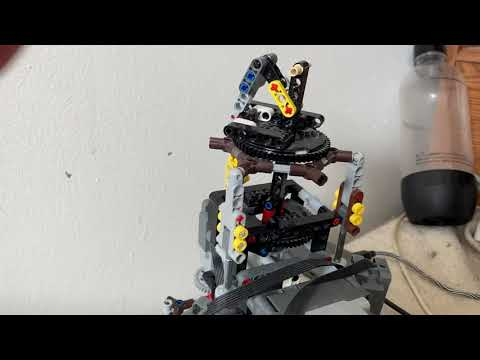

In [7]:
from IPython.display import YouTubeVideo

YouTubeVideo('3EfkG8Fx6pY')

### References

This animate of an S-61 Sea King rotor head was invaluable in my understanding of how a helicopter works.

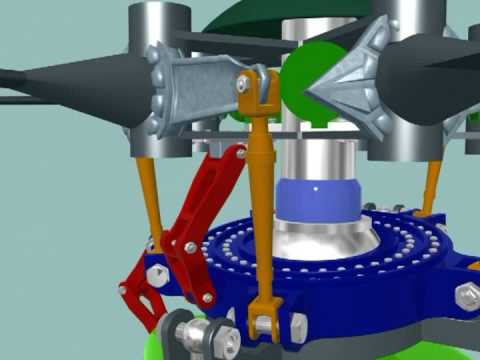

In [8]:
YouTubeVideo('83h6QK-oJ4M')

 - [What Is CCPM, on an RC Helicopter & Why it's Important?](https://www.rchelicopterfun.com/ccpm.html)
 - [Cyclic/collective pitch mixing (wikipedia)](https://en.wikipedia.org/wiki/Cyclic/collective_pitch_mixing)